# Lab 1: Estimating Basin Waterbalance

## 2. Setting up the Lab

- [`hydrodata`](https://hydrodata.readthedocs.io/en/latest/index.html) is a Python library designed to aid in  watershed analysis. 
- Hydrodata is capable of downloading, preprocessing, and visualizing climatological, hydrological, and geographical datasets pertaining to a given watershed.
- Supported datasets include: Daymet climate, USGS streamflow, and data from the National Land Cover Dataset.

#### 2.1 Hydrodata

- It's easy to use `hydrodata` to get streamflow data for any USGS gauge.  
- Your lab work will focus on a stream gauge near to some favorite (or personally interesting) place in the U.S.

In [1]:
import pandas as pd
from hydrodata import Station
import hydrodata.datasets as hds
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") # Don't output warnings

# 3. Background

- The main concept we will be considering is mass balance. 
- Along with energy and momentum, mass is one of the three consitutents that are conserved in environmental systems. 
- Physical systems can be written as a statement of mass, energy, or momentum. 
- The key to creating these statements (or equations) of balance is determining the bounds of the system (it's geographic extent and structure) as well as the specific processes acting across those boundaries. 

In [2]:
station_id = '11138500'  # This is a USGS station ID. Later, I will show you how to find one on your own!
start = '2015-10-01'     # Start date is the Oct. 1, 2016 which is the start of the 2016-2017 water year.
end = '2018-09-30'       # End date is the Sept 30, 2019 which is the end of the 2018-2019 water year.

# Create our watershed object using the station_id, start, and end dates
wshed = Station(start=start, end=end, station_id=station_id, data_dir="../data/lab_1/")

## Viewing Watershed Hydrography 

We can use some of the dataset interfaces provided by `hydrodata` to map the stream channels within our watershed. 

Access to the NHDPlus dataset is provided by the `NLDI` object, which is part of `hydrodata`'s `datasets` class, which we imported earlier as `hds`. To query these datasets, we use the following code:


In [3]:
# Find the hydrography associated with this station using the wshed.station_id:
tributaries = hds.NLDI.tributaries(wshed.station_id)
main_channel = hds.NLDI.main(wshed.station_id)
stations = hds.NLDI.stations(wshed.station_id)

## Viewing Watershed Hydrography 


We can then plot these data using internal `hydrodata` plotting functions, which are special versions of `matplotlib` plotting functions with extra features for viewing our stream channels.


Text(0.5, 1.0, 'Sisquoc River near Sisquoc, CA (120.17°W, 34.84°N)')

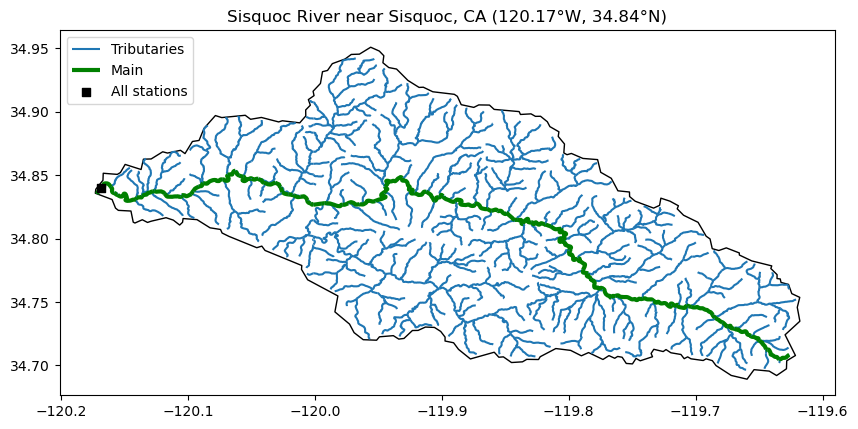

In [4]:
# Create a plot of the basin boundaries, main channel, tributaries, and station locations. 
ax = wshed.basin.plot(color='white', edgecolor='black', zorder=1, figsize = (10, 10))
tributaries.plot(ax=ax, label='Tributaries', zorder=2)
main_channel.plot(ax=ax, color='green', lw=3, label='Main', zorder=3)
stations.plot(ax=ax, color='black', label='All stations', marker='s', zorder=5)
ax.legend(loc='upper left');
ax.figure.set_dpi(100);
ax.set_title(u'Sisquoc River near Sisquoc, CA ({lon:.2f}\U000000b0W, {lat:.2f}\U000000b0N)'.format(
    lon=abs(wshed.lon),
    lat=wshed.lat))

## Viewing Basin Topography Using Digital Elevation Data
We can get a better sense of this topography using Digital Elevation Data released by the USGS. 


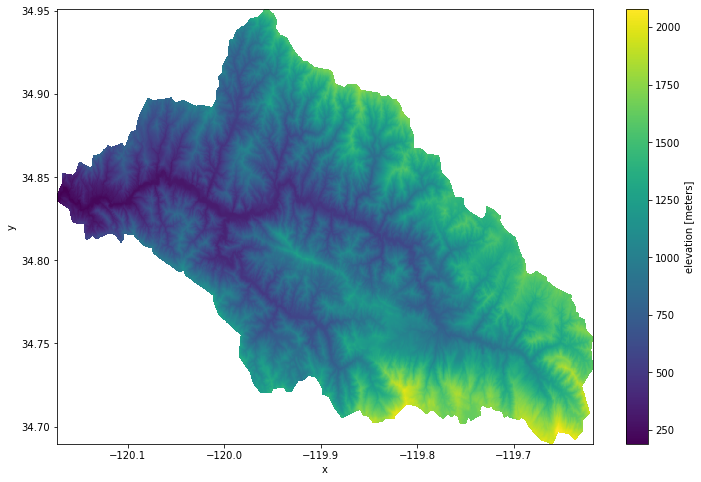

In [5]:
# Grab the watershed Digital Elevation Data from the USGS and display it:
dem = hds.nationalmap_dem(wshed.geometry, resolution=1)
dem.plot(size=8);

## A Catchment as a Physical System

The water balance of a catchment is determined by the sum of inputs and outputs of water. If inputs are greater than outputs, the catchment is gaining water. If outputs are greater than inputs, the catchment is losing water. In the special case where outputs and inputs are equal, the catchment is neither gaining nor losing water, and the amount of water in the catchment is constant with time, meaning it is in _steady state_. 

The change in storage of water in the catchment ($\Delta S$, [m$^3$]) can be written as:

$ \Delta S = P - ET - Q $


Usually, we calculate the water balance over discrete time intervals, $\Delta t$ (e.g. days, or years), in which case, the equation becomes:

$\frac{\Delta S}{\Delta t} = P(t) - ET(t) - Q(t) $

and we have implicitly re-defined the units of $P$, $ET$, and $Q$ to be mass per time, [m$^3$/t].

## Obtaining Precipitation, Discharge, and Rainfall data for a USGS station

So far, we've been able to define a catchment upstream of a USGS gauge and visualize basin stream networks and topography. In order to study our simple basin water balance, we will need to obtain data on each of the three main fluxes: $Q$, $P$, and $ET$. 

### Discharge Data for our Station

The `hydrodata` allows us to access streamflow data stored in the National Water Information System ([NWIS](https://www.usgs.gov/nwis-national-water-information-system)), which contains water resource data for almost 1.5 million locations across the United States and US Territories. 

In [7]:
Q = hds.nwis_streamflow(wshed.station_id, wshed.start, wshed.end)
Q.columns = ['Q [m^3/s]']
Q.index.name = 'Datetime'
Q['Dates'] = Q.index
Q.tail()

,Q [m^3/s],Dates
Datetime,,
2018-09-26,0.003115,2018-09-26
2018-09-27,0.003681,2018-09-27
2018-09-28,0.004531,2018-09-28
2018-09-29,0.005380,2018-09-29
2018-09-30,0.005097,2018-09-30


### Precipitation Data for our Station

Unfortunately, most USGS streamflow gauges aren't at locations where rainfall data is also collected. Even if they were, rainfall varies across even small basins, so we'd still need to have some idea of what the average rainfall was over the entire watershed. Helpfully, the `hydromet` library includes the ability to query the Daily Surface Weather and Climatological Summaries ([Daymet](https://daymet.ornl.gov)), which is hosted at Oak Ridge National Laboratory's (ORNL's) Distributed Active Archive Center (DAAC). 

In [8]:
daymet = hds.daymet_byloc(wshed.lon, wshed.lat, start=wshed.start, end=wshed.end)
daymet.head()

,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa)
2015-10-01,41817.601562,0.0,400.000000,0.0,29.0,13.5,560.0
2015-10-02,41817.601562,0.0,400.000000,0.0,28.0,12.5,520.0
2015-10-03,41472.000000,0.0,403.200012,0.0,27.0,11.0,480.0
2015-10-04,41472.000000,2.0,310.399994,0.0,22.0,11.0,480.0
2015-10-05,41126.398438,0.0,387.200012,0.0,24.0,9.0,400.0


In [9]:
P = pd.DataFrame(daymet['prcp (mm/day)'])
P.columns = ['P [mm/day]']
P.index.name = 'Datetime'
P['Dates'] = P.index
P.head()

,P [mm/day],Dates
Datetime,,
2015-10-01,0.0,2015-10-01
2015-10-02,0.0,2015-10-02
2015-10-03,0.0,2015-10-03
2015-10-04,2.0,2015-10-04
2015-10-05,0.0,2015-10-05


### Evapotranspiration Data for our Station

Evapotranspiration data is the hardest to obtain as there are very few direct observations of evapotranspiration (but we will work with some of these direct measurements in our next lab!). For this lab, we are going to use a model-based estimate of actual evapotranspiration called the Operational Simplified Surface Energy Balance (SSEBop) model, which was developed at the USGS's Earth Resources Observation and Science ([EROS](https://www.usgs.gov/centers/eros)) Center.  

We can access the SSEBop model estimates of evapotranspiration using the `ssedopeta_byloc` method:


In [10]:
# Let's, load some SSEBop data that we've already downloaded from a csv using the pd.read_csv() command:
ET = pd.read_csv('../data/lab_1/SSEBop_11123500.csv', usecols=['ET [mm/day]', 'datetime'], index_col='datetime')

# Just as with our P and Q data, we assign the index and create a column of dates.
ET.index.name = 'Datetime'
ET['Dates'] = ET.index
ET.head()

,ET [mm/day],Dates
Datetime,,
2015-10-01,0.52,2015-10-01
2015-10-02,0.52,2015-10-02
2015-10-03,0.52,2015-10-03
2015-10-04,0.52,2015-10-04
2015-10-05,0.52,2015-10-05


## Hydromet Plotting tools

The `hydrodata` package includes a handy utility for plotting streamflow and rainfall. I've modified this utility to give us a way to quickly look at the time series of our rainfall and streamflow data. 

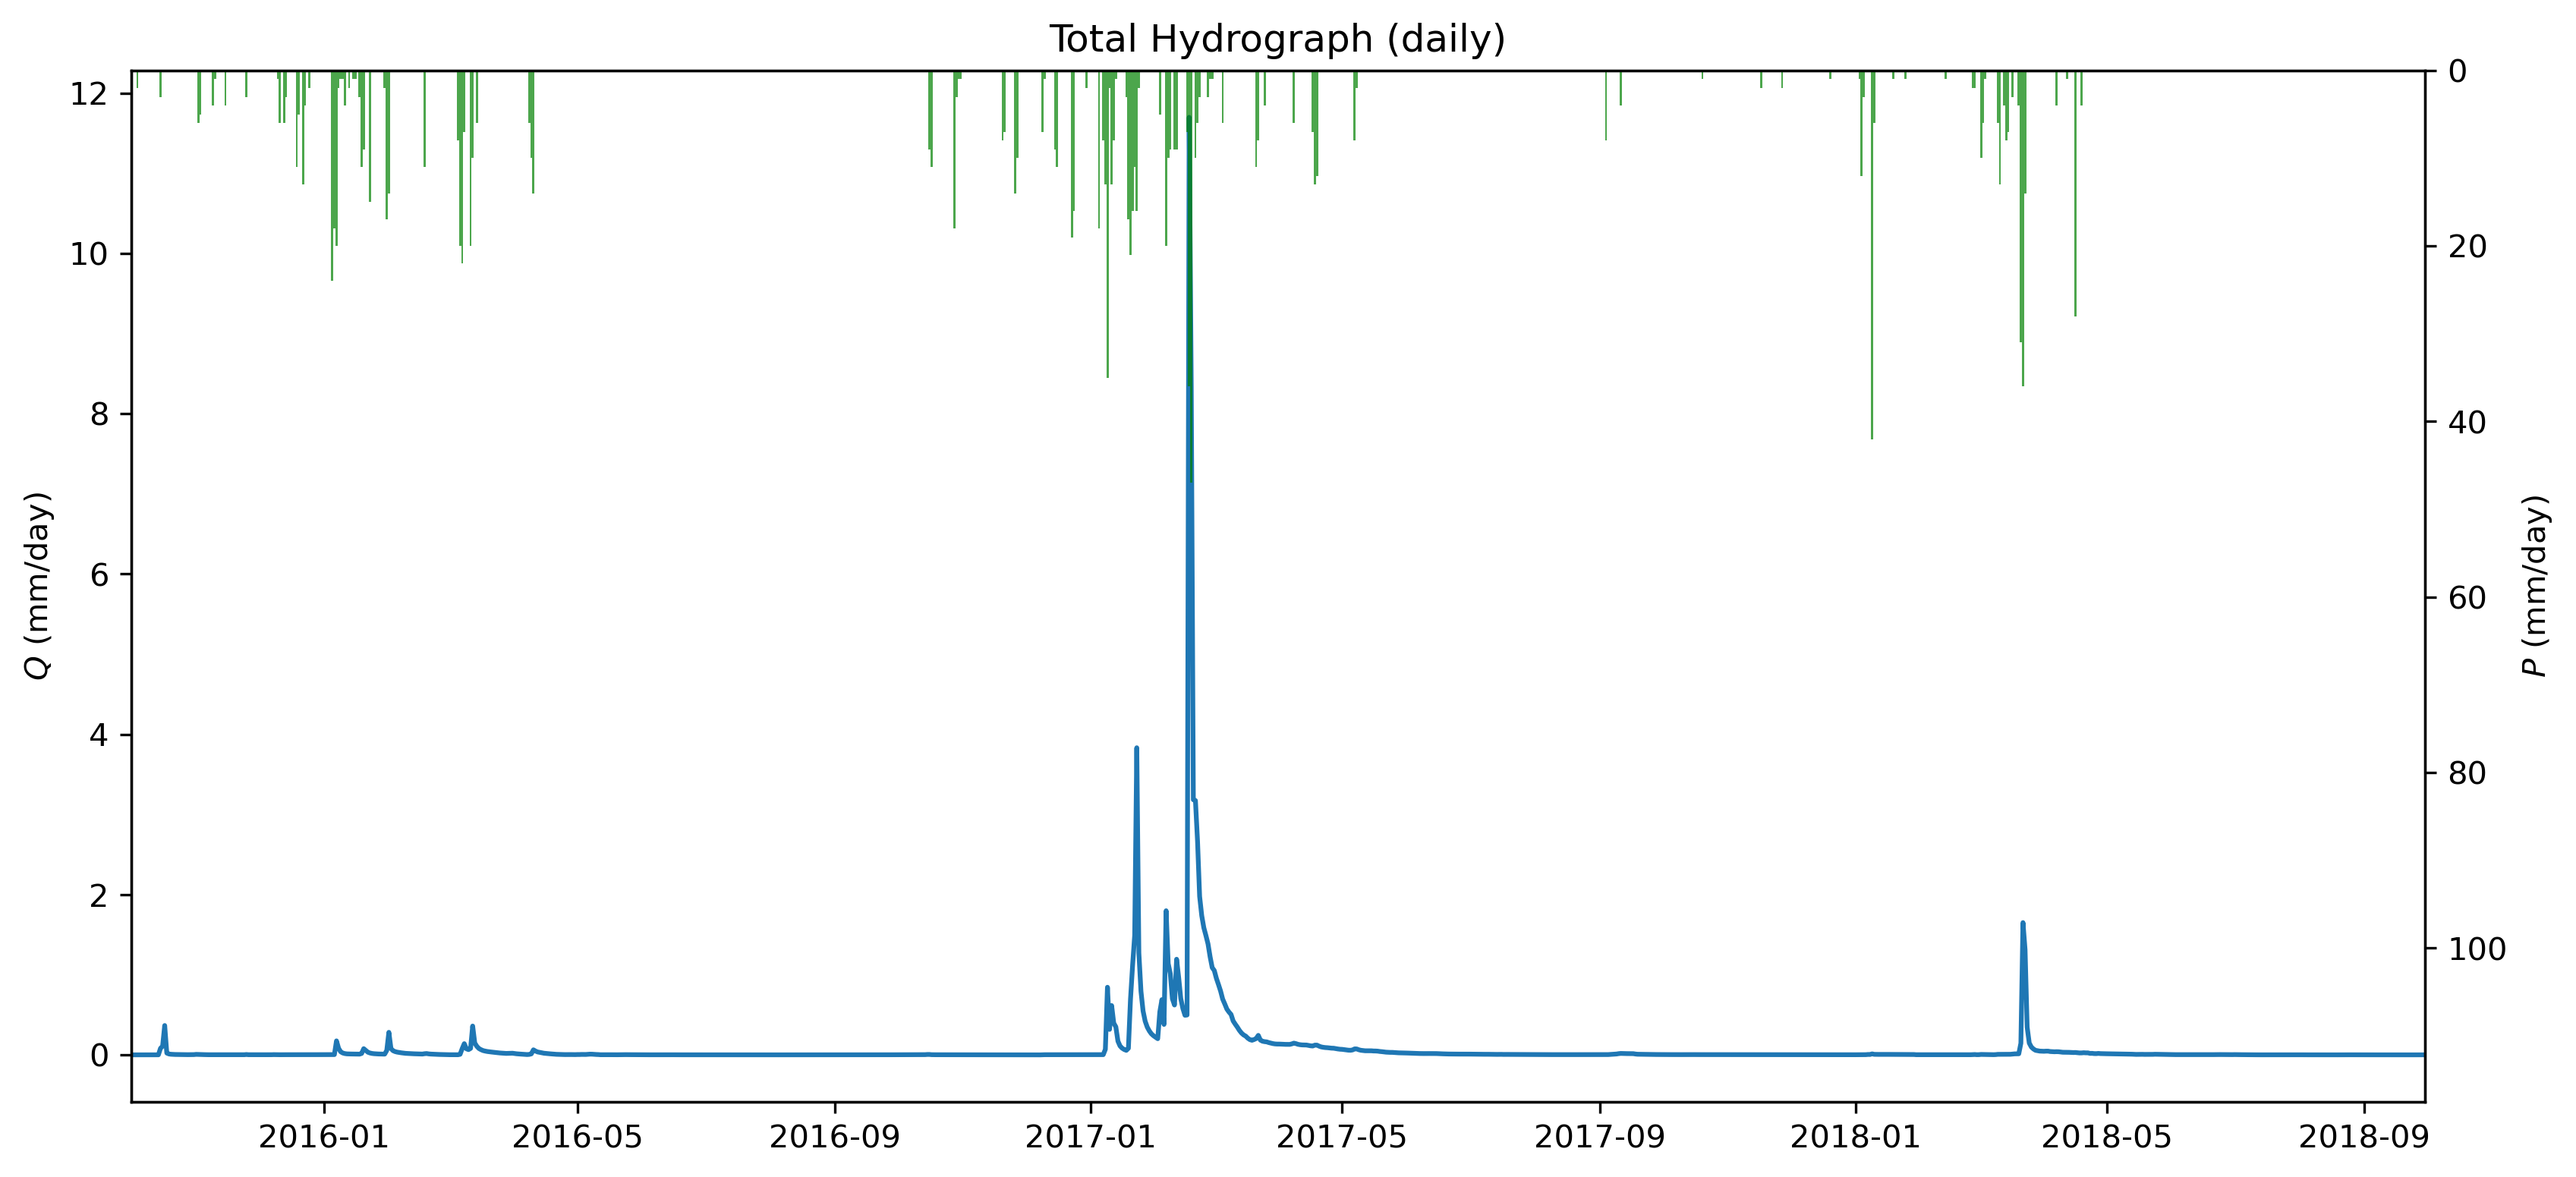

In [11]:
# Visualize streamflow and rainfall data from our station
from plot_Q_and_P import plot_Q_and_P

plot_Q_and_P({"Q": (Q['Q [m^3/s]'], wshed.drainage_area)}, P['P [mm/day]'], figsize=(13,6))

## Extra Stuff: Land Use Data

While we don't use it in this lab, `hydrodata` also makes it possible to access land use and land cover data can be obtained from the Multi-Resolution Land Characteristics (MRLC) Consortium. By default the data are downloaded from NLCD 2016.

In [12]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from hydrodata import plot as hydroplot

cmap, norm, levels = hydroplot.cover_legends()
# Download LULC data for this watershed
lulc = hds.nlcd(wshed.geometry, resolution=1)

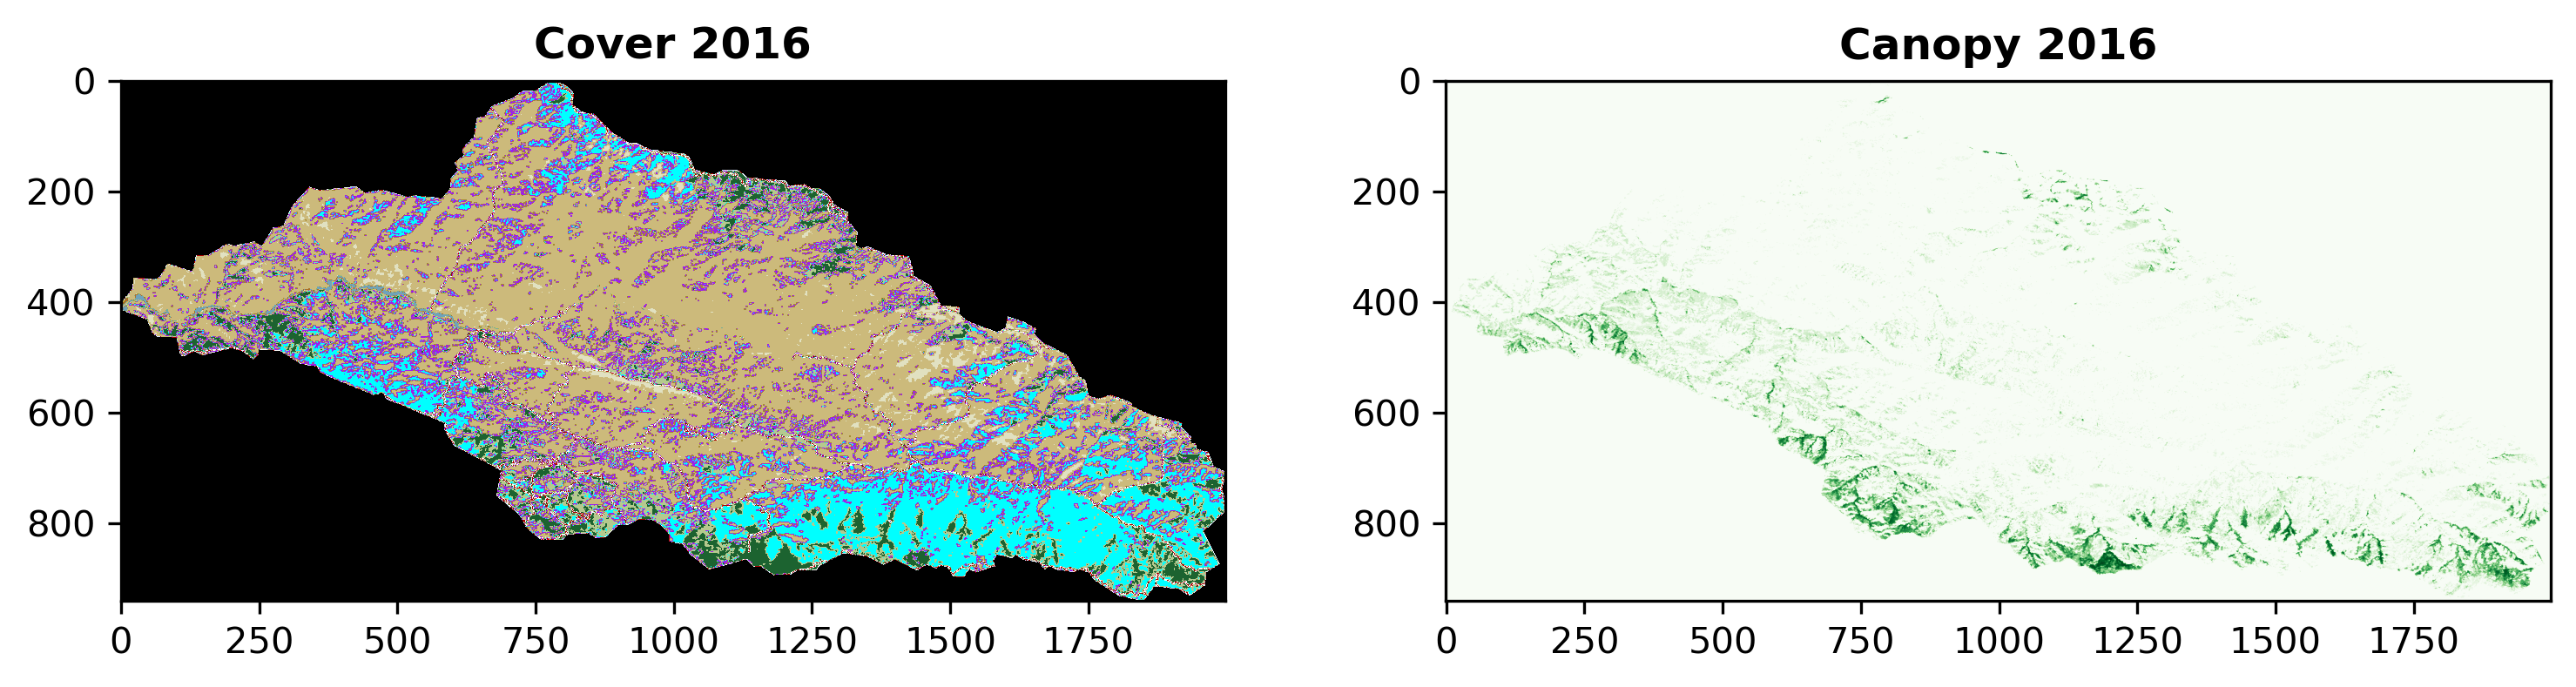

In [13]:
# Plot the watershed Land Cover and Canopy Cover for 2016
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7), dpi=300)
show(lulc['cover'], ax=ax1, title=f'Cover 2016', cmap=cmap, norm=norm)
show(lulc['canopy'], ax=ax2, title=f'Canopy 2016', cmap='Greens')

# The End